#  Wasserstein GAN with Gradient Penalty (WGAN-GP) -MNIST Augmentation

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
from tqdm.auto import trange

## Utilities

In [2]:
def plot_results(images, n_cols=None, title=None):
    
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    fig = plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
        
    plt.suptitle(title)

In [3]:
BATCH_SIZE = 128
CODINGS_SIZE = 32
N_EPOCHS = 100
D_STEPS = 5
GP_WEIGHT = 10.0

# Prepare the Dataset

In [4]:
def prepare_data(label, batch_size):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    X_all = X_all.astype(np.float32) / 255
    X_all = X_all.reshape(-1, 28, 28, 1) * 2. - 1.
    X_train = X_all[np.where(y_all == label)]

    dataset = tf.data.Dataset.from_tensor_slices(X_train)
    dataset = dataset.shuffle(1024)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)
    
    return dataset


def prepare_images(label):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    X_all = X_all.astype(np.float32) / 255
    X_all = X_all.reshape(-1, 28, 28, 1) * 2. - 1.
    X_train = X_all[np.where(y_all == label)]
    
    return X_train

# Build the Model

The original Wasserstein GAN leverages the Wasserstein distance to produce a value function that has better theoretical properties than the value function used in the original GAN paper. WGAN requires that the discriminator (aka the critic) lie within the space of 1-Lipschitz functions. The authors proposed the idea of weight clipping to achieve this constraint. Though weight clipping works, it can be a problematic way to enforce 1-Lipschitz constraint and can cause undesirable behavior, e.g. a very deep WGAN discriminator (critic) often fails to converge.

The WGAN-GP method proposes an alternative to weight clipping to ensure smooth training. Instead of clipping the weights, the authors proposed a "gradient penalty" by adding a loss term that keeps the L2 norm of the discriminator gradients close to 1.

### Generator

For the generator, we take in random noise and eventually transform it to the shape of the MNIST images. The general steps are:

* Feed the input noise to a dense layer.
* Reshape the output to have three dimensions. This stands for the (length, width, number of filters).
* Perform a deconvolution (with Conv2DTranspose), reducing the number of filters by half and using a stride of `2`.
* The final layer upsamples the features to the size of the training images. In this case 28 x 28 x 1.

Notice that batch normalization is performed except for the final deconvolution layer. As best practice, `selu` is the activation used for the intermediate deconvolution while `tanh` is for the output.

### Discriminator

The discriminator will use strided convolutions to reduce the dimensionality of the input images. As best practice, these are activated by LeakyRELU. The output features will be flattened and fed to a 1-unit dense layer without any activation.

In [5]:
def build_generator():
    inputs = keras.Input(shape=[CODINGS_SIZE])
    x = keras.layers.Dense(7 * 7 * 128)(inputs)
    x = keras.layers.Reshape([7, 7, 128])(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="selu")(x)
    x = keras.layers.BatchNormalization()(x)
    skip = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="selu")(x)
    skip = keras.layers.BatchNormalization()(skip)
    skip = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="selu")(skip)
    skip = keras.layers.BatchNormalization()(skip)
    x = keras.layers.add([x, skip])
    x = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="SAME",activation="selu")(x)
    skip = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="selu")(x)
    skip = keras.layers.BatchNormalization()(skip)
    skip = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="selu")(skip)
    skip = keras.layers.BatchNormalization()(skip)
    x = keras.layers.add([x, skip])
    outputs = keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME",activation="tanh")(x)
    return keras.models.Model(inputs, outputs, name='generator')

In [6]:
def build_discriminator():
    return keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=3, strides=1, padding="SAME", activation=keras.layers.LeakyReLU(0.2), input_shape=[28, 28, 1]),
    keras.layers.Conv2D(128, kernel_size=3, strides=1, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=3, strides=1, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Conv2D(128, kernel_size=3, strides=1, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
], name='discriminator')

In [7]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=5,
        gp_weight=10.0,
    ):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator.
        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)
                real_logits = self.discriminator(real_images, training=True)

                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                d_loss = d_cost + gp * self.gp_weight

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            g_loss = self.g_loss_fn(gen_img_logits)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}    
    
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)    

Generator Summary


Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 6272)         206976      input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 7, 7, 128)    0           dense[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 7, 7, 128)    512         reshape[0][0]                    
______________________________________________________________________

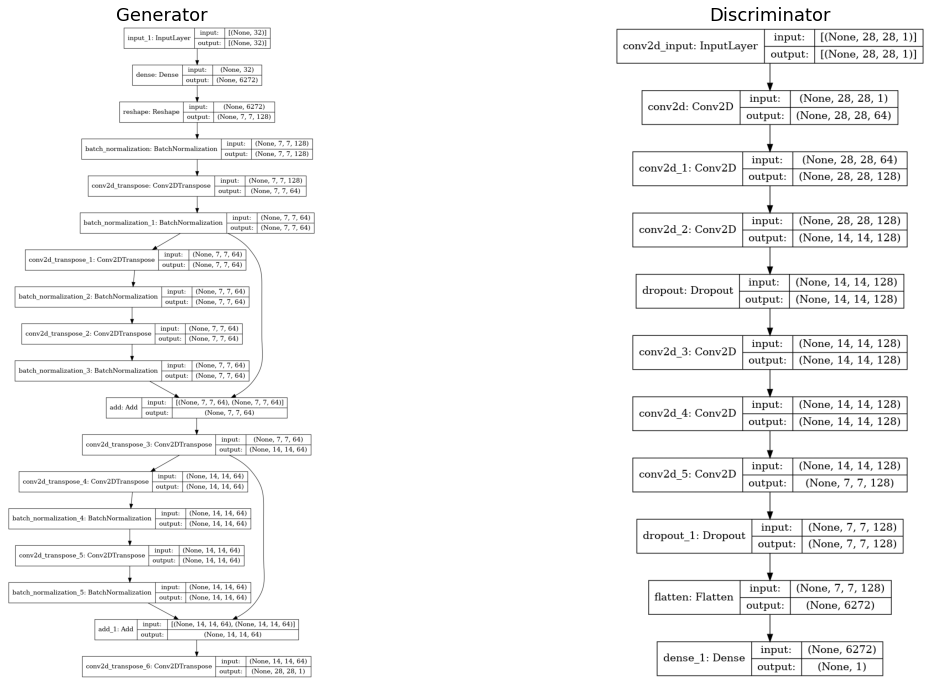

In [8]:
generator = build_generator()
discriminator = build_discriminator()
print('Generator Summary\n\n')
generator.summary()
print('\n\nDiscriminator Summary\n\n')
discriminator.summary()
keras.utils.plot_model(generator, show_shapes=True, expand_nested=True, to_file='generator.png')
keras.utils.plot_model(discriminator, show_shapes=True, expand_nested=True, to_file='discriminator.png')
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
ax[0].imshow(plt.imread('generator.png'))
ax[0].set_title('Generator', fontsize=18)
ax[1].imshow(plt.imread('discriminator.png'))
ax[1].set_title('Discriminator', fontsize=18)
ax[0].axis("off")
ax[1].axis("off")
plt.show()

# GAN in Action

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/100
53/53 [==============================] - 36s 403ms/step - d_loss: -32.8162 - g_loss: 12.8760
Epoch 2/100
53/53 [==============================] - 21s 403ms/step - d_loss: -23.5952 - g_loss: 19.1060
Epoch 3/100
53/53 [==============================] - 21s 403ms/step - d_loss: -13.4786 - g_loss: 13.1306
Epoch 4/100
53/53 [==============================] - 21s 403ms/step - d_loss: -7.3931 - g_loss: 10.4139
Epoch 5/100
53/53 [==============================] - 21s 403ms/step - d_loss: -4.1038 - g_loss: 8.4954
Epoch 6/100
53/53 [==============================] - 21s 402ms/step - d_loss: -3.6450 - g_loss: 8.9536
Epoch 7/100
53/53 [==============================] - 21s 403ms/step - d_loss: -3.4692 - g_loss: 14.2484
Epoch 8/100
53/53 [==============================] - 21s 402ms/step - d_loss: -3.2594 - g_loss: 14.8939
Epoch 9/100
53/53 [==============================] - 21s 402ms/step - d_loss: -2.7454 - g_loss: 19.372

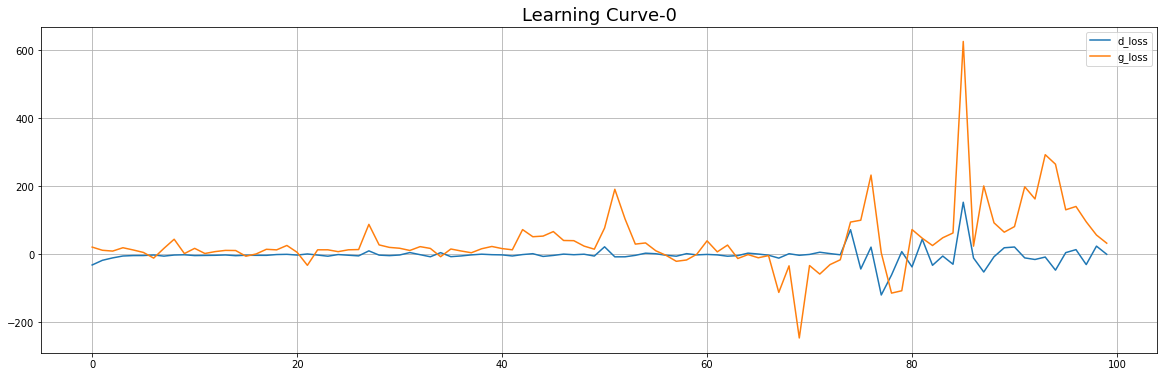

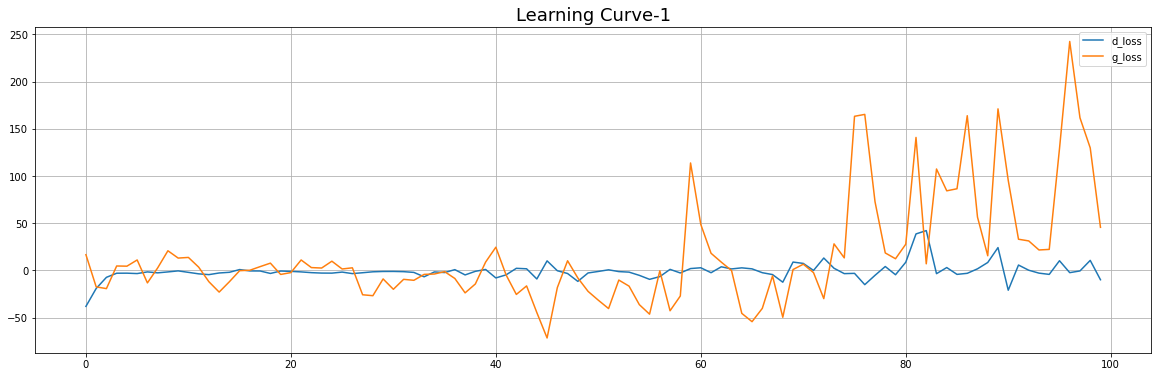

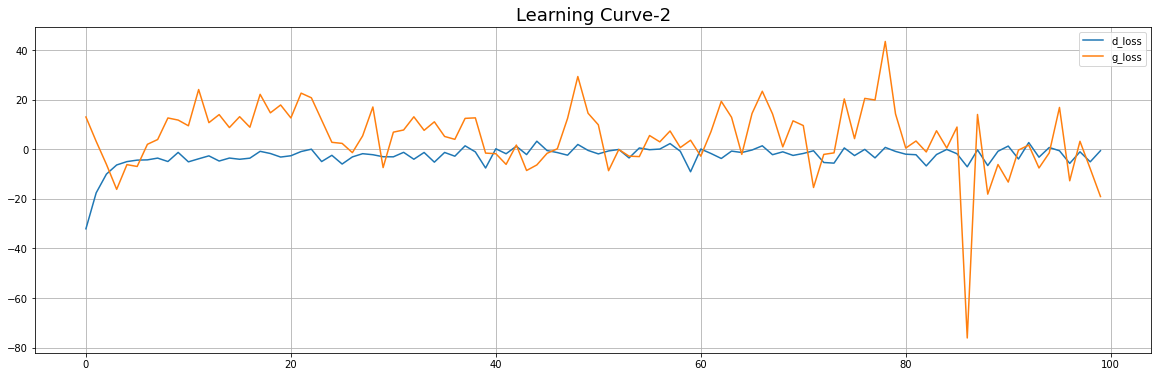

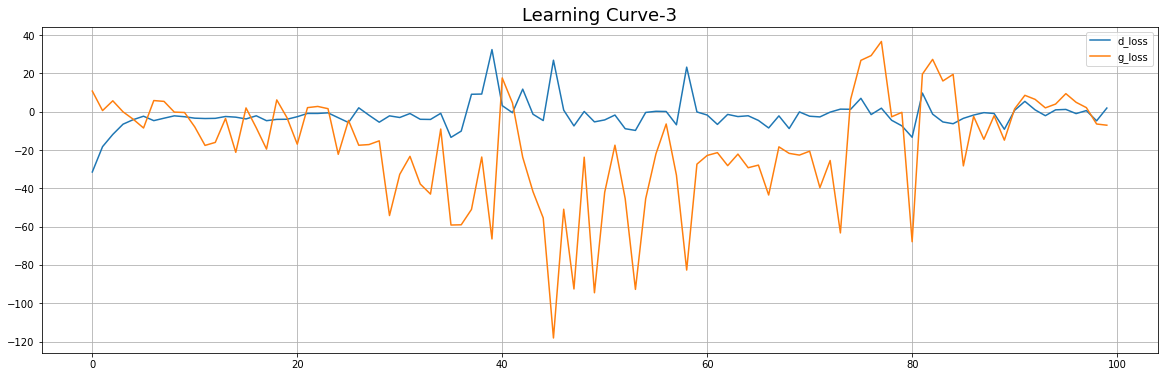

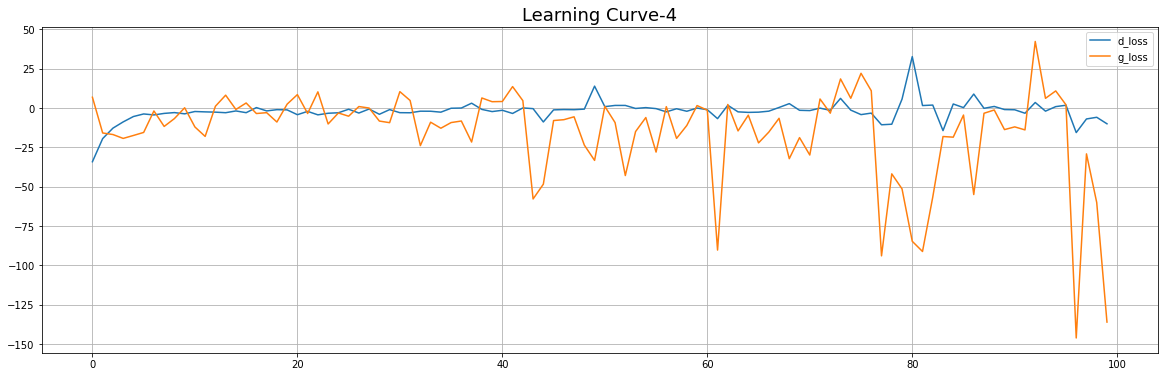

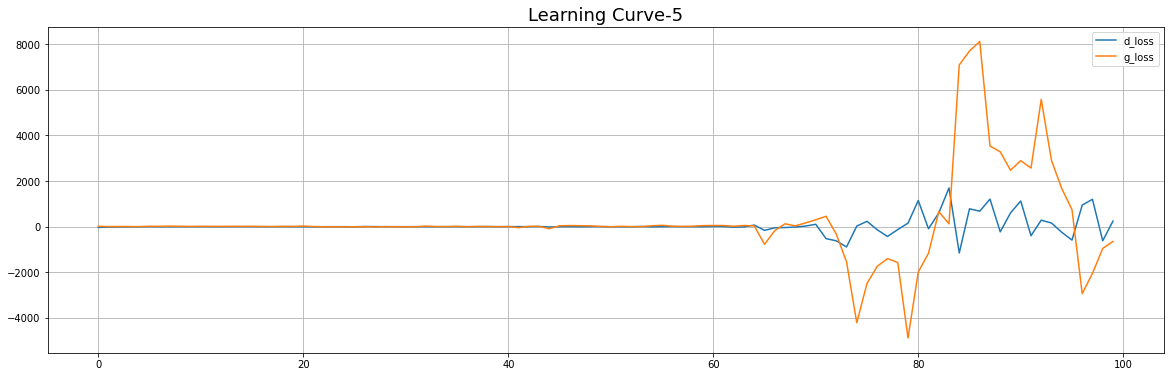

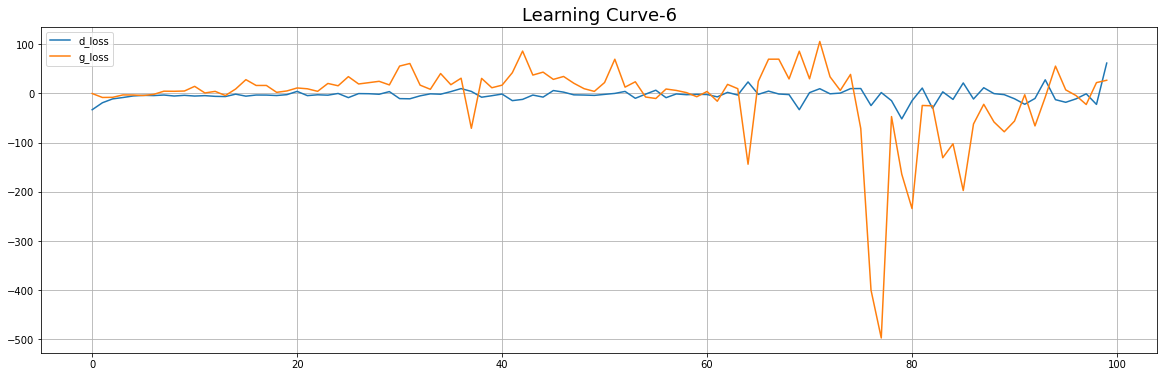

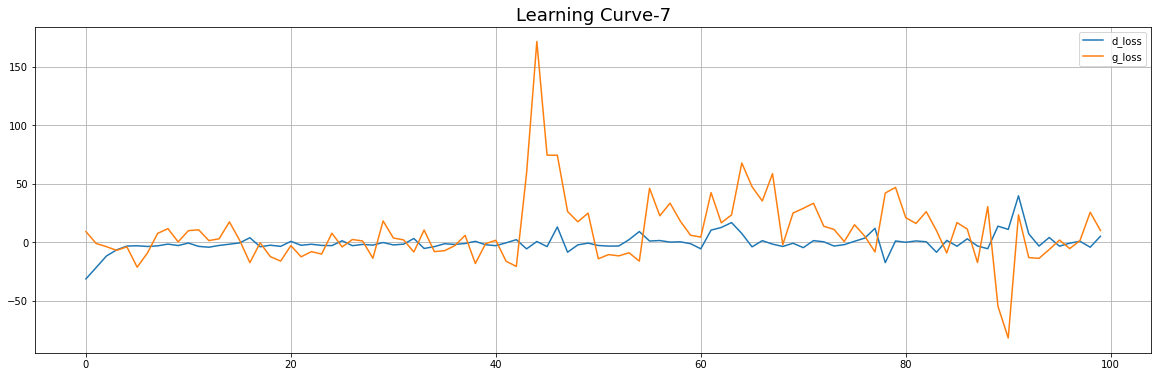

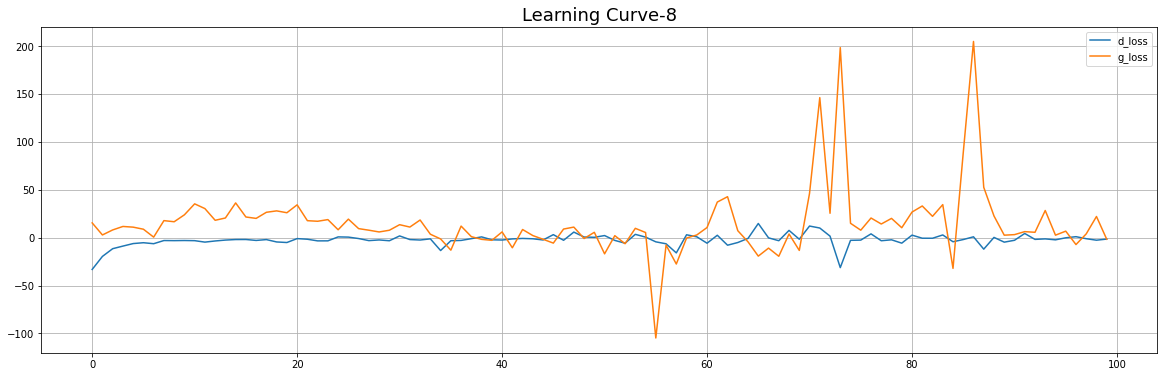

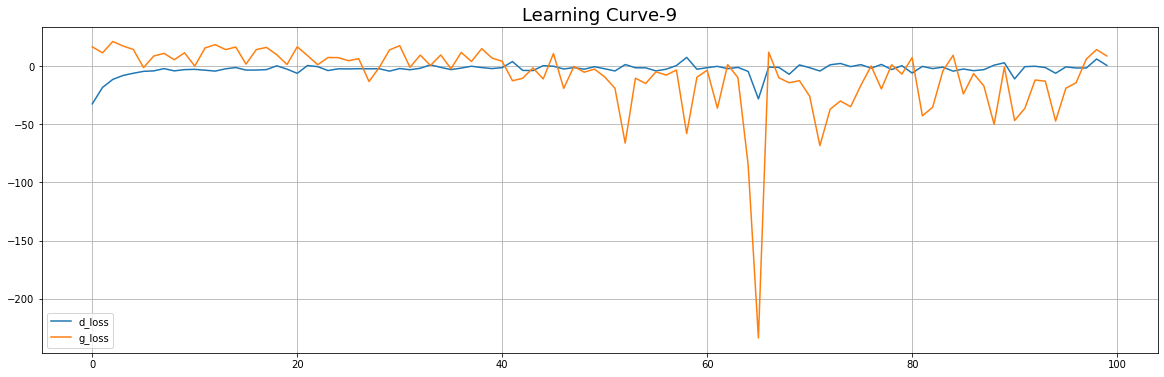

In [9]:
for i in range(10):
    LABEL = i
    dataset = prepare_data(LABEL, BATCH_SIZE)

    generator = build_generator()
    discriminator = build_discriminator()
    
    gan = WGAN(
        discriminator=discriminator, generator=generator, 
        latent_dim=CODINGS_SIZE, discriminator_extra_steps=D_STEPS, gp_weight=GP_WEIGHT
    )
    gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        g_loss_fn=generator_loss,
        d_loss_fn=discriminator_loss,
    )
    
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.set_title(f'Learning Curve-{LABEL}', fontsize=18)
    history = gan.fit(dataset, epochs=N_EPOCHS, verbose=1)
    pd.DataFrame(history.history).plot(ax=ax)
    ax.grid()
       
    generator.save(f'MNIST-AUG-WGAN-{LABEL}.h5')

# Generated Images

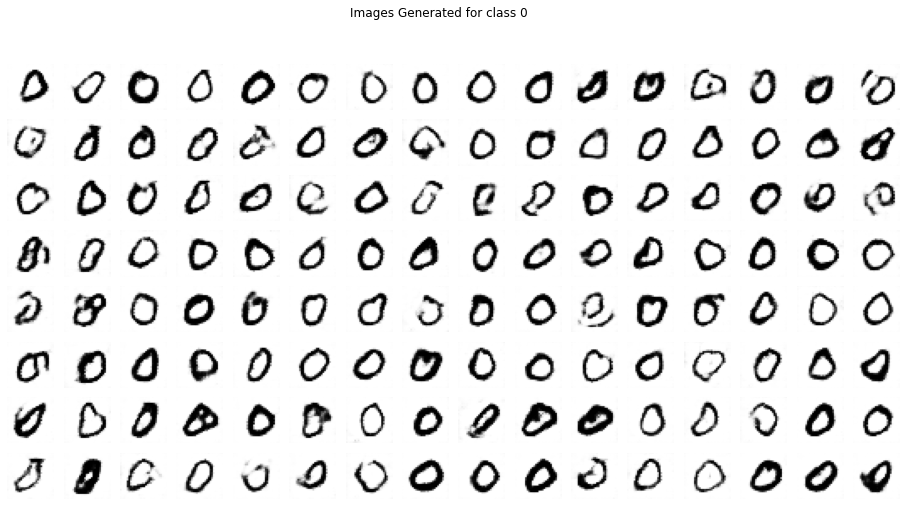

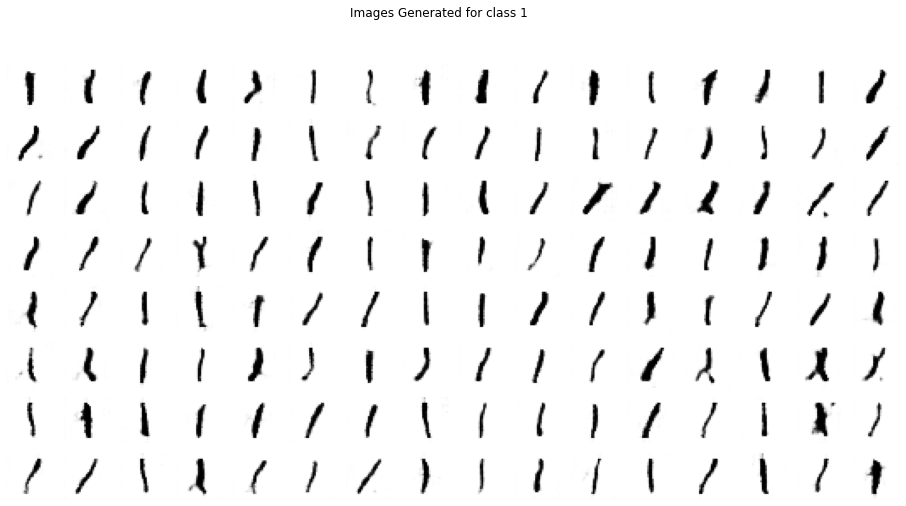

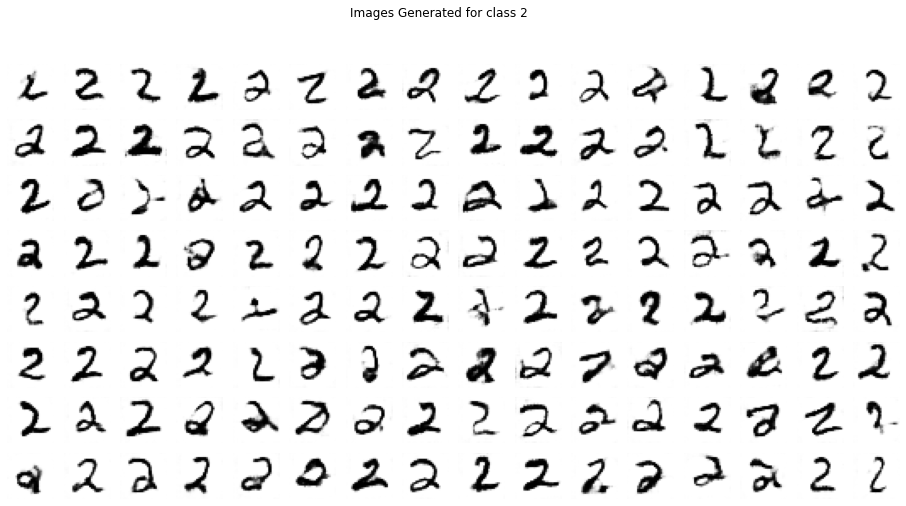

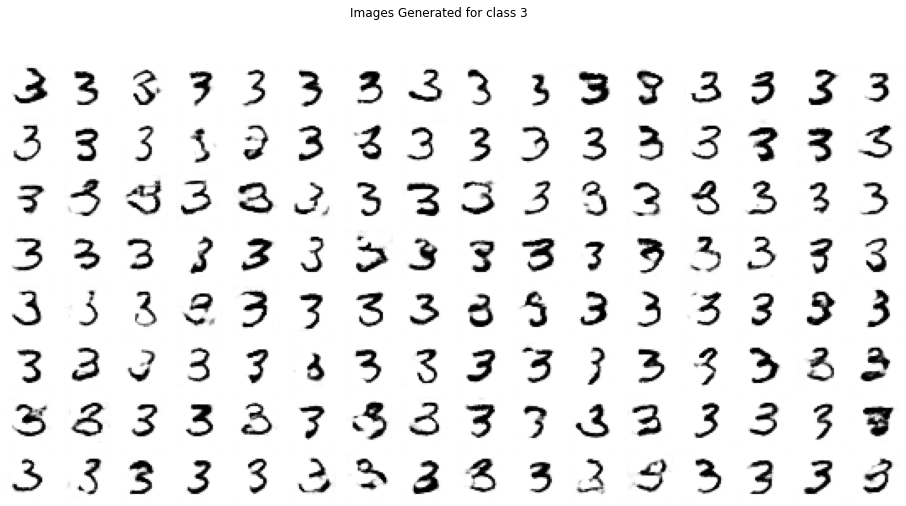

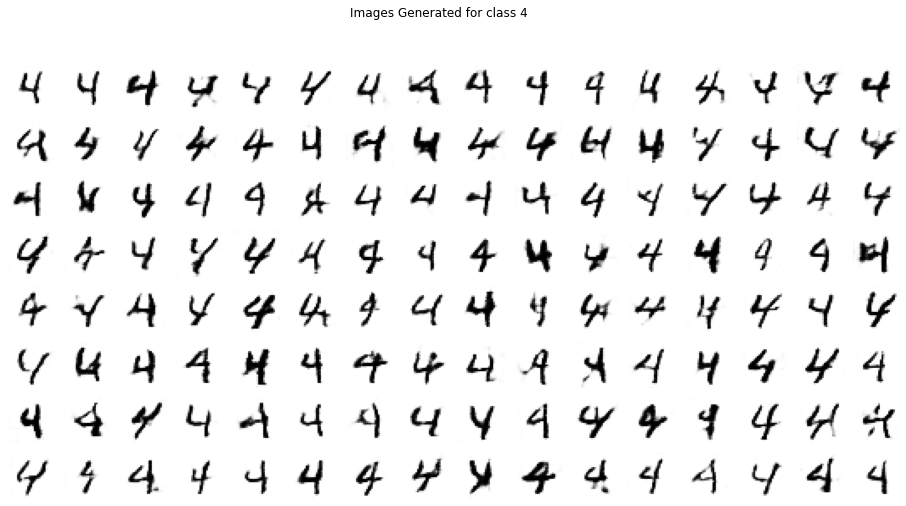

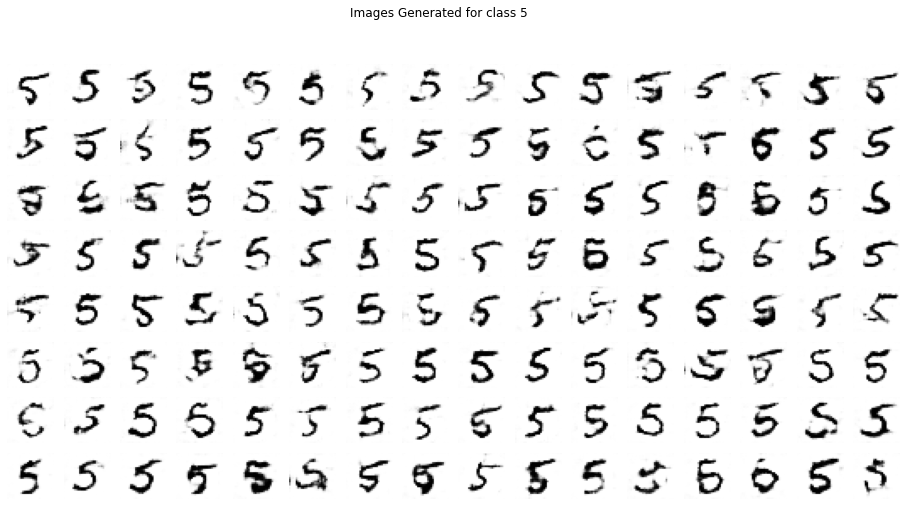

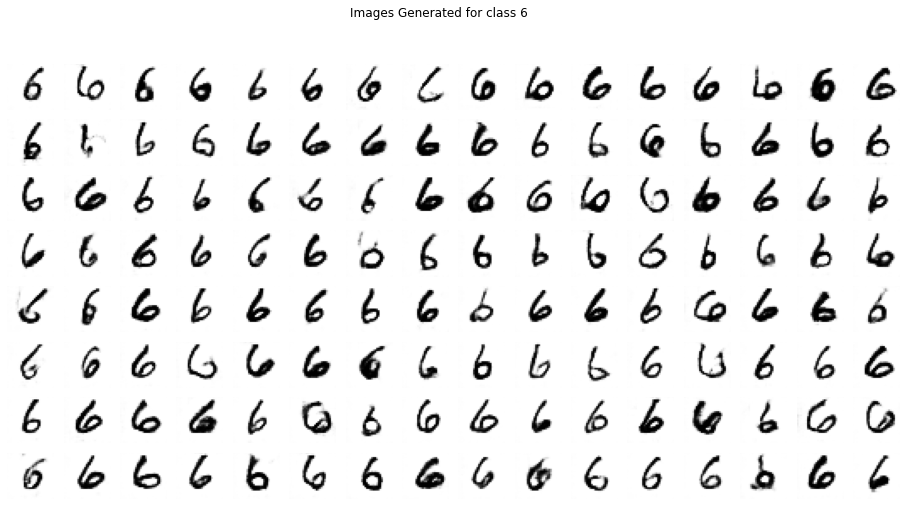

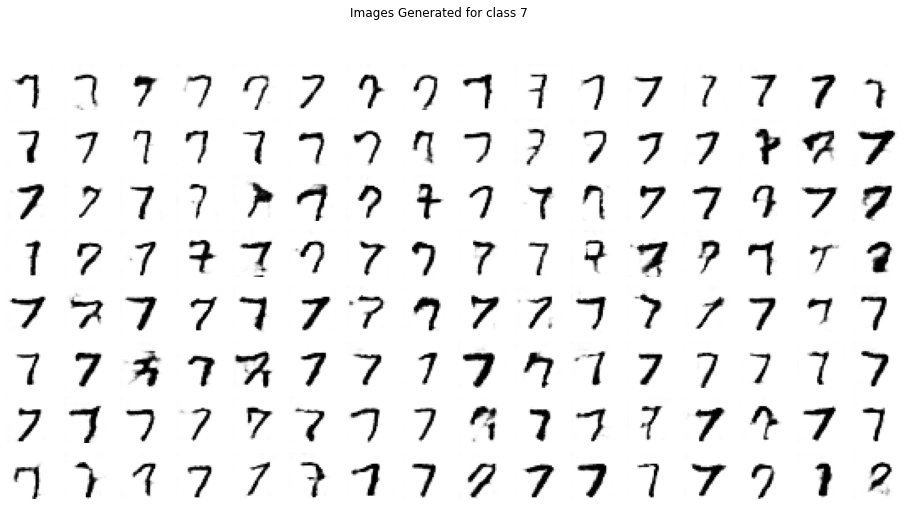

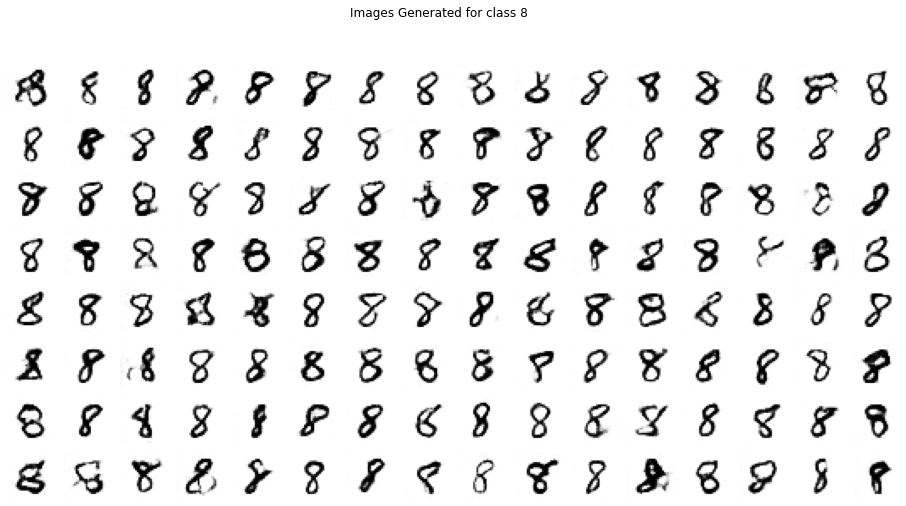

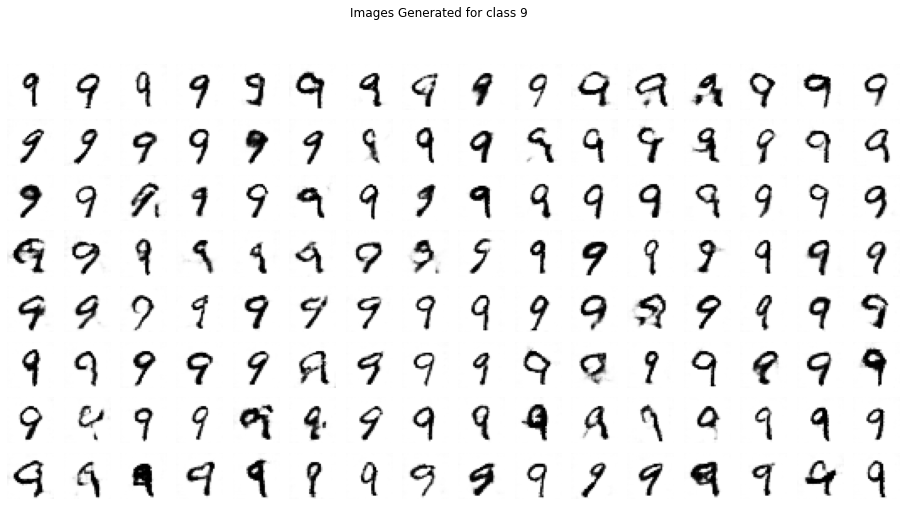

In [10]:
from scipy.linalg import sqrtm

def frechet_distance(act1, act2):
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

evaluator = keras.models.Sequential(keras.models.load_model('../input/mnist-net/mnist_net.h5').layers[:-1])
scores = []

for i in range(10):
    generator = keras.models.load_model(f'MNIST-AUG-WGAN-{i}.h5')
    fake_images = generator(tf.random.normal([128, CODINGS_SIZE]))
    embeddings_real = evaluator(prepare_images(i))
    embeddings_fake = evaluator(fake_images)
    scores.append(frechet_distance(embeddings_real, embeddings_fake))
    plot_results(fake_images, 16, f'Images Generated for class {i}')                     
    plt.show()  

# Evaluation

In [11]:
pd.Series(scores, name="Frechet Distance")

0    49.976616
1    27.996682
2    20.366248
3    11.024833
4    21.361350
5    30.757507
6    17.900417
7    15.673079
8    21.523774
9    20.164678
Name: Frechet Distance, dtype: float64